In [24]:
print("dataset_sdn.csv")

dataset_sdn.csv


In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

In [26]:

data = pd.read_csv('dataset_sdn.csv')
data.head()


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [27]:
data.shape

(104345, 23)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [29]:
##### Here we see that the label contains boolean values: 0 - Benign, 1-Maliciuous 
data.label.unique()

array([0, 1])

In [30]:
data.label.value_counts()

label
0    63561
1    40784
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

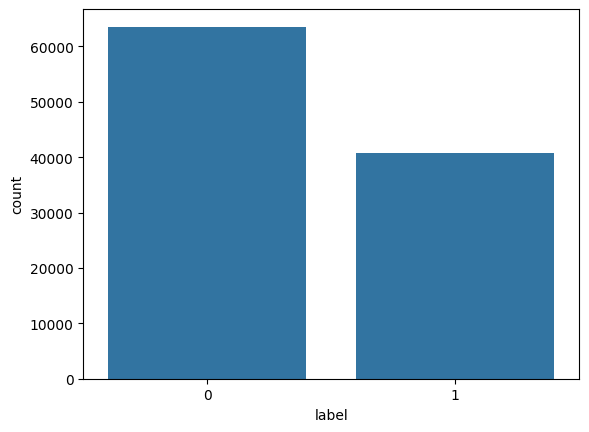

In [31]:
label_dict = dict(data.label.value_counts())
sns.countplot(x='label', data=data)


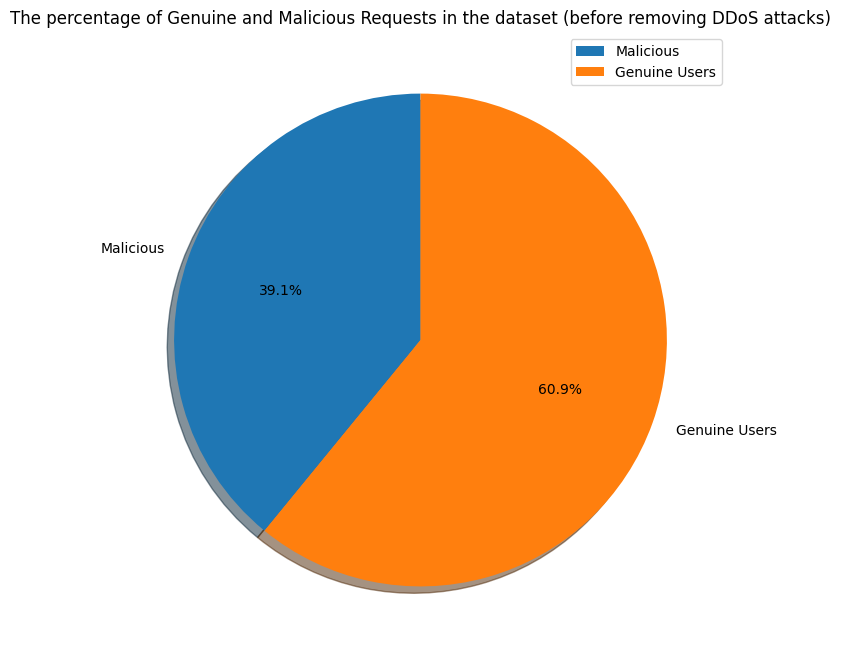

In [32]:
# Count the total number of malicious and genuine users
malicious_count = data['label'].value_counts()[1]  # Assuming 1 indicates malicious
genuine_users_count = data['label'].value_counts()[0]  # Assuming 0 indicates genuine users

# Update the labels and sizes for the pie chart
labels = ["Malicious", "Genuine Users"]
sizes = [malicious_count, genuine_users_count]

# Plot the pie chart with corrected labels
plt.figure(figsize=(13, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(labels)
plt.title('The percentage of Genuine and Malicious Requests in the dataset (before removing DDoS attacks)')
plt.show()

In [33]:
data.describe()

,dt,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
count,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,1.043450e+05,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,1.043450e+05,104345.000000,103839.000000,103839.000000,104345.000000
mean,17927.514169,4.214260,52860.954746,3.818660e+07,321.497398,4.613880e+08,3.218865e+11,5.654234,5200.383468,6381.715291,4.716150e+06,212.210676,0.600987,2.331094,9.325264e+07,9.328039e+07,998.899756,1003.811420,2007.578742,0.390857
std,11977.642655,1.956327,52023.241460,4.877748e+07,283.518232,2.770019e+08,2.834029e+11,2.950036,5257.001450,7404.777808,7.560116e+06,246.855123,0.489698,1.084333,1.519380e+08,1.330004e+08,2423.471618,2054.887034,3144.437173,0.487945
min,2488.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.000000,4.000000,-130933.000000,-1.464426e+08,-4365.000000,0.000000,1.000000,2.527000e+03,8.560000e+02,0.000000,0.000000,0.000000,0.000000
25%,7098.000000,3.000000,808.000000,7.957600e+04,127.000000,2.340000e+08,1.270000e+11,3.000000,1943.000000,29.000000,2.842000e+03,0.000000,0.000000,1.000000,4.743000e+03,3.539000e+03,0.000000,0.000000,0.000000,0.000000
50%,11905.000000,4.000000,42828.000000,6.471930e+06,251.000000,4.180000e+08,2.520000e+11,5.000000,3024.000000,8305.000000,5.521680e+05,276.000000,1.000000,2.000000,4.219610e+06,1.338339e+07,0.000000,0.000000,4.000000,0.000000
75%,29952.000000,5.000000,94796.000000,7.620354e+07,412.000000,7.030000e+08,4.130000e+11,7.000000,7462.000000,10017.000000,9.728112e+06,333.000000,1.000000,3.000000,1.356398e+08,1.439277e+08,251.000000,557.000000,3838.000000,1.000000
max,42935.000000,10.000000,260006.000000,1.471280e+08,1881.000000,9.990000e+08,1.880000e+12,17.000000,25224.000000,19190.000000,1.495387e+07,639.000000,1.000000,5.000000,1.269982e+09,9.905962e+08,20580.000000,16577.000000,20580.000000,1.000000


Text(0.5, 1.0, 'Features which has NuLL values')

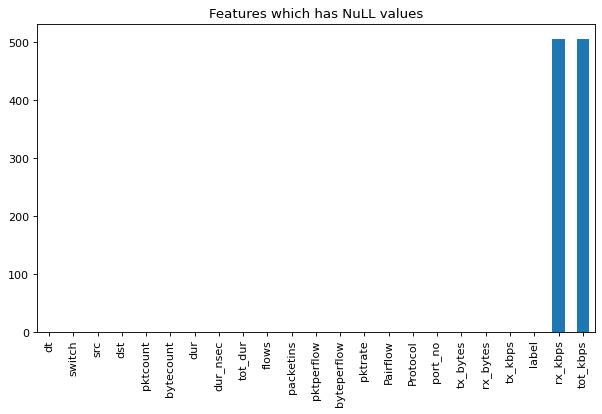

In [34]:
# Let's look at the vizualisation of Null valued features
figure(figsize=(9, 5), dpi=80)
data[data.columns[data.isna().sum() >= 0]].isna().sum().sort_values().plot.bar()
plt.title("Features which has NuLL values")

In [35]:
data.isnull().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

In [36]:
#### Let's support which columns NUMERIC and which is OBJECT

numeric_df = data.select_dtypes(include=['int64', 'float64'])
object_df = data.select_dtypes(include=['object'])
numeric_cols = numeric_df.columns
object_cols = object_df.columns
print('Numeric Columns: ')
print(numeric_cols, '\n')
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Numeric Features: ', len(numeric_cols))
print('Number of Object Features: ', len(object_cols))


object_df.head()



Numeric Columns: 
Index(['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps', 'label'],
      dtype='object') 

Object Columns: 
Index(['src', 'dst', 'Protocol'], dtype='object') 

Number of Numeric Features:  20
Number of Object Features:  3


,src,dst,Protocol
0,10.0.0.1,10.0.0.8,UDP
1,10.0.0.1,10.0.0.8,UDP
2,10.0.0.2,10.0.0.8,UDP
3,10.0.0.2,10.0.0.8,UDP
4,10.0.0.2,10.0.0.8,UDP


Text(0.5, 1.0, 'Number of all reqests')

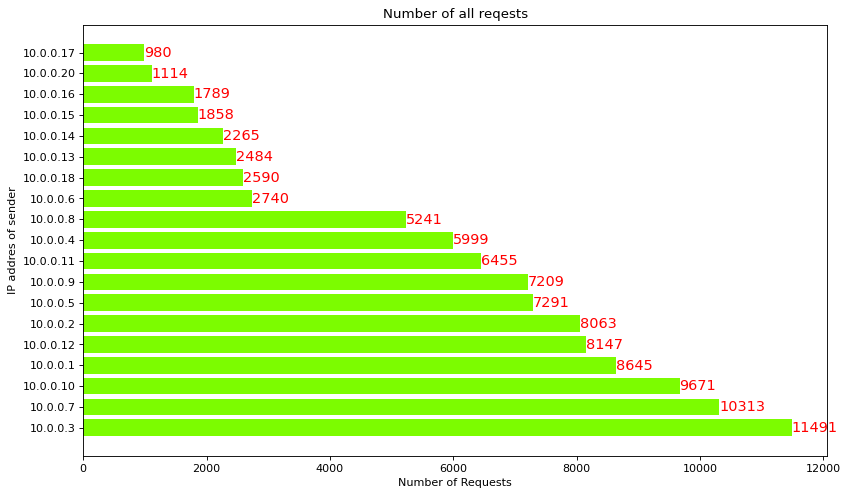

In [37]:


#### Let's look at Oblect columns (Source Destination Protocol)

figure(figsize=(12, 7), dpi=80)
plt.barh(list(dict(data.src.value_counts()).keys()), dict(data.src.value_counts()).values(), color='lawngreen')

for idx, val in enumerate(dict(data.src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

plt.xlabel('Number of Requests')
plt.ylabel('IP addres of sender')
plt.title('Number of all reqests')


Text(0.5, 1.0, 'Number of Attack requests')

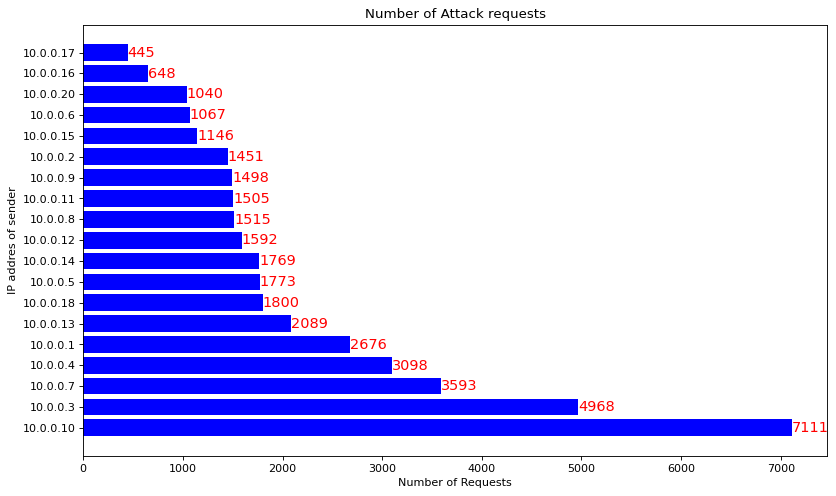

In [38]:
figure(figsize=(12, 7), dpi=80)
plt.barh(list(dict(data[data.label == 1].src.value_counts()).keys()), dict(data[data.label == 1].src.value_counts()).values(), color='blue')

for idx, val in enumerate(dict(data[data.label == 1].src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

plt.xlabel('Number of Requests')
plt.ylabel('IP addres of sender')
plt.title('Number of Attack requests')

Text(0.5, 1.0, 'Number of requests from different IP adress')

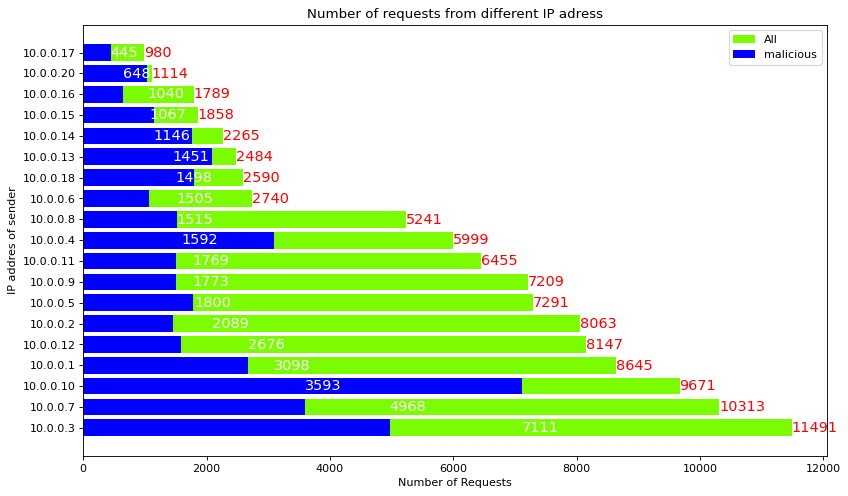

In [39]:
figure(figsize=(12, 7), dpi=80)
plt.barh(list(dict(data.src.value_counts()).keys()), dict(data.src.value_counts()).values(), color='lawngreen')
plt.barh(list(dict(data[data.label == 1].src.value_counts()).keys()), dict(data[data.label == 1].src.value_counts()).values(), color='blue')

for idx, val in enumerate(dict(data.src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

for idx, val in enumerate(dict(data[data.label == 1].src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='w', size = 13)


plt.xlabel('Number of Requests')
plt.ylabel('IP addres of sender')
plt.legend(['All','malicious'])
plt.title('Number of requests from different IP adress')


Text(0.5, 1.0, 'The number of requests from different protocols')

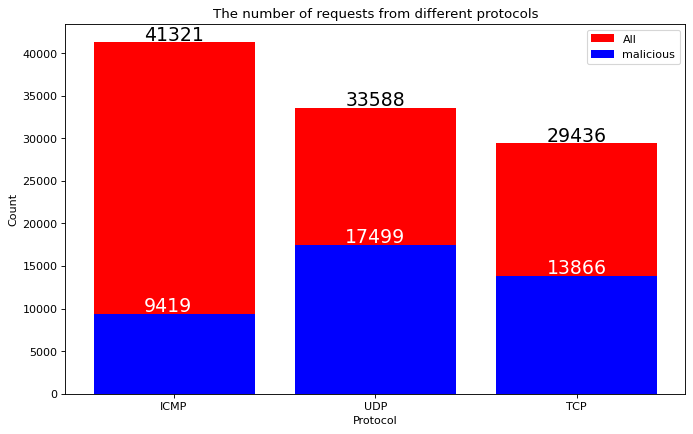

In [40]:
figure(figsize=(10, 6), dpi=80)
plt.bar(list(dict(data.Protocol.value_counts()).keys()), dict(data.Protocol.value_counts()).values(), color='r')
plt.bar(list(dict(data[data.label == 1].Protocol.value_counts()).keys()), dict(data[data.label == 1].Protocol.value_counts()).values(), color='b')

plt.text(x = 0 - 0.15, y = 41321 + 200, s = str(41321), color='black', size=17)
plt.text(x = 1 - 0.15, y = 33588 + 200, s = str(33588), color='black', size=17)
plt.text(x = 2 - 0.15, y = 29436 + 200, s = str(29436), color='black', size=17)

plt.text(x = 0 - 0.15, y = 9419 + 200, s = str(9419), color='w', size=17)
plt.text(x = 1 - 0.15, y = 17499 + 200, s = str(17499), color='w', size=17)
plt.text(x = 2 - 0.15, y = 13866 + 200, s = str(13866), color='w', size=17)

plt.xlabel('Protocol')
plt.ylabel('Count')
plt.legend(['All', 'malicious'])
plt.title('The number of requests from different protocols')

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
class Model:
    global y
    def __init__(self, data):
        self.data = data
        X = preprocessing.StandardScaler().fit(self.data).transform(self.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=42, test_size=0.3)  
    
    def LogisticRegression(self):
        solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

        start_time = time.time()
        results_lr = []
        accuracy_list = []
        for solver in solvers:
            LR = LogisticRegression(C=0.03, solver=solver).fit(self.X_train, self.y_train)
            predicted_lr = LR.predict(self.X_test)
            accuracy_lr = accuracy_score(self.y_test, predicted_lr)
            #print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))
            #print('################################################################')
            results_lr.append({'solver' : solver, 'accuracy': str(round(accuracy_lr * 100, 2)) + "%", 
                                  'Coefficients': {'W' : LR.coef_, 'b': LR.intercept_}})
            
            accuracy_list.append(accuracy_lr)
       
        solver_name = solvers[accuracy_list.index(max(accuracy_list))]
        LR = LogisticRegression(C=0.03, solver=solver_name).fit(self.X_train,self.y_train)
        predicted_lr = LR.predict(self.X_test)
        accuracy_lr = accuracy_score(self.y_test, predicted_lr)
        print("Accuracy: %.2f%%" % (accuracy_lr * 100.0), '\n')
        print("########################################################################")
        print('Best solver is : ', solver_name)
        print("########################################################################")
        print(classification_report(predicted_lr, self.y_test), '\n')
        print("########################################################################")
        print("--- %s seconds --- time for LogisticRegression" % (time.time() - start_time))
        print("Classification Report for Logistic Regression:")
        print(classification_report(predicted_lr, self.y_test))
        
        
        
    def KNearetsNeighbor(self):
        start_time = time.time()
        Ks = 12
        accuracy_knn = np.zeros((Ks-1))
        std_acc = np.zeros((Ks-1))
        #print(accuracy_knn)
        for n in range(1,Ks):

            #Train Model and Predict  
            neigh = KNeighborsClassifier(n_neighbors = n).fit(self.X_train,self.y_train)
            yhat=neigh.predict(self.X_test)
            accuracy_knn[n-1] = metrics.accuracy_score(self.y_test, yhat)


            std_acc[n-1]=np.std(yhat==self.y_test)/np.sqrt(yhat.shape[0])

        #print(accuracy_knn,'\n\n') # courseranyn ozinde tek osy gana jazylyp turdy
        #print(std_acc)
        #accuracy_knn[0] = 0
        plt.figure(figsize=(10,6))
        plt.plot(range(1,Ks),accuracy_knn,'g')
        plt.fill_between(range(1,Ks),accuracy_knn - 1 * std_acc,accuracy_knn + 1 * std_acc, alpha=0.10)
        plt.fill_between(range(1,Ks),accuracy_knn - 3 * std_acc,accuracy_knn + 3 * std_acc, alpha=0.10,color="green")
        plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
        plt.ylabel('Accuracy ')
        plt.xlabel('Number of Neighbors (K)')
        plt.tight_layout()
        plt.show()
        
        
        knnc = KNeighborsClassifier()
        knnc_search = GridSearchCV(knnc, param_grid={'n_neighbors': [3, 5, 10],
                                             'weights': ['uniform', 'distance'],
                                             'metric': ['euclidean', 'manhattan']},
                           n_jobs=-1, cv=3, scoring='accuracy', verbose=2)
        
        knnc_search.fit(self.X_train, self.y_train)
        #print(knnc_search.best_params_)
        #print(knnc_search.best_score_)
        n_neighbors = knnc_search.best_params_['n_neighbors']
        weights = knnc_search.best_params_['weights']
        metric = knnc_search.best_params_['metric']
        KNN = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights).fit(self.X_train,self.y_train)
        
        predicted_knn = KNN.predict(self.X_test)
        accuracy_knn = metrics.accuracy_score(self.y_test, predicted_knn)
        print(f"Accuracy of KNN model {round(accuracy_knn,2)*100}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_knn, self.y_test))
        print("########################################################################")
        print("--- %s seconds ---" % (time.time() - start_time))
        
  


In [42]:
# Prediction Without Feature Selection
# Data preprocessing from here onwards
df = data.copy()
df = df.dropna()
X = df.drop(['dt','src','dst','label'], axis=1)
y = df.label
X = pd.get_dummies(X)
M = Model(X)
M.LogisticRegression()


Accuracy: 76.64% 

########################################################################
Best solver is :  liblinear
########################################################################
              precision    recall  f1-score   support

           0       0.84      0.79      0.81     20024
           1       0.66      0.72      0.69     11128

    accuracy                           0.77     31152
   macro avg       0.75      0.76      0.75     31152
weighted avg       0.77      0.77      0.77     31152
 

########################################################################
--- 3.3112926483154297 seconds --- time for LogisticRegression
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81     20024
           1       0.66      0.72      0.69     11128

    accuracy                           0.77     31152
   macro avg       0.75      0.76      0.75     31152
weighted avg       0.77

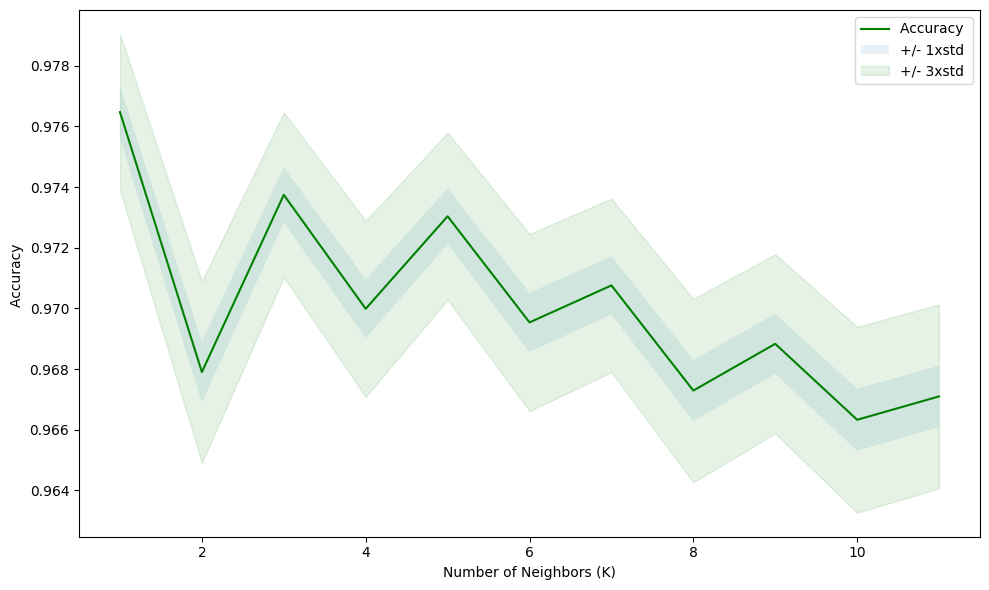

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Accuracy of KNN model 98.0% 

########################################################################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19002
           1       0.98      0.98      0.98     12150

    accuracy                           0.98     31152
   macro avg       0.98      0.98      0.98     31152
weighted avg       0.98      0.98      0.98     31152

########################################################################
--- 297.6607565879822 seconds ---


In [43]:
M.KNearetsNeighbor()

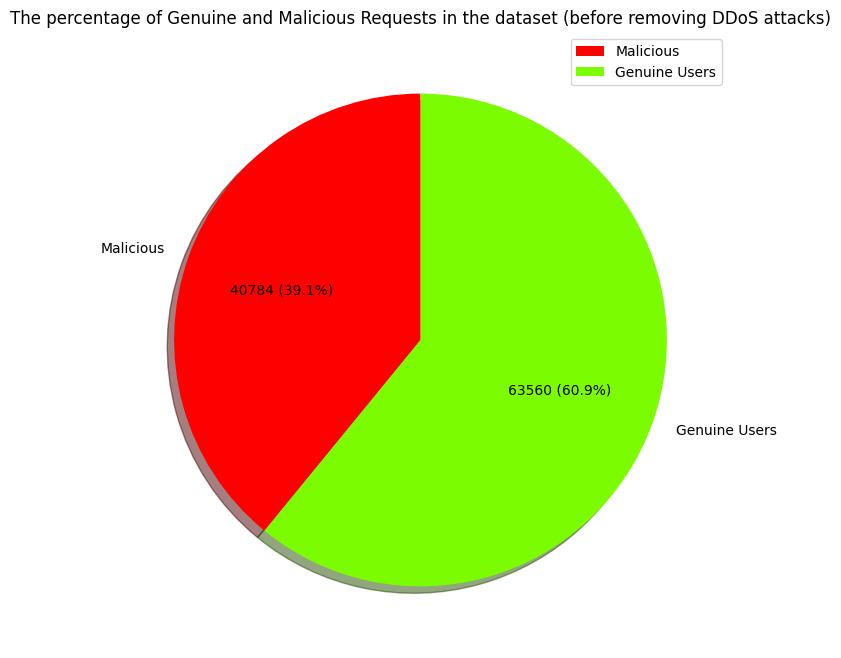

In [44]:
# Count the total number of malicious and benign users before removal
initial_malicious_count = data[data['label'] == 1].shape[0]
initial_genuine_users_count = data[data['label'] == 0].shape[0]

# Update the labels and sizes for the pie chart
labels = ["Malicious", "Genuine Users"]
sizes = [initial_malicious_count, initial_genuine_users_count]

# Define a function to format the labels with both count and percentage
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f'{absolute} ({pct:.1f}%)'

# Display the number of Genuine Users and remaining malicious users
#print(f"Number of Genuine Users: {initial_genuine_users_count}")
#print(f"Number of malicious users: {initial_malicious_count}")

# Plot the pie chart before removing malicious users
plt.figure(figsize=(13, 8))
plt.pie(sizes, labels=labels, autopct=lambda pct: func(pct, sizes), shadow=True, startangle=90, colors=["red", "lawngreen"])
plt.legend(["Malicious", "Genuine Users"])
plt.title('The percentage of Genuine and Malicious Requests in the dataset (before removing DDoS attacks)')
plt.show()


Number of removed malicious users (DDoS attacks): 40784
Number of Genuine  Users: 63561
Number of remaining malicious users: 0


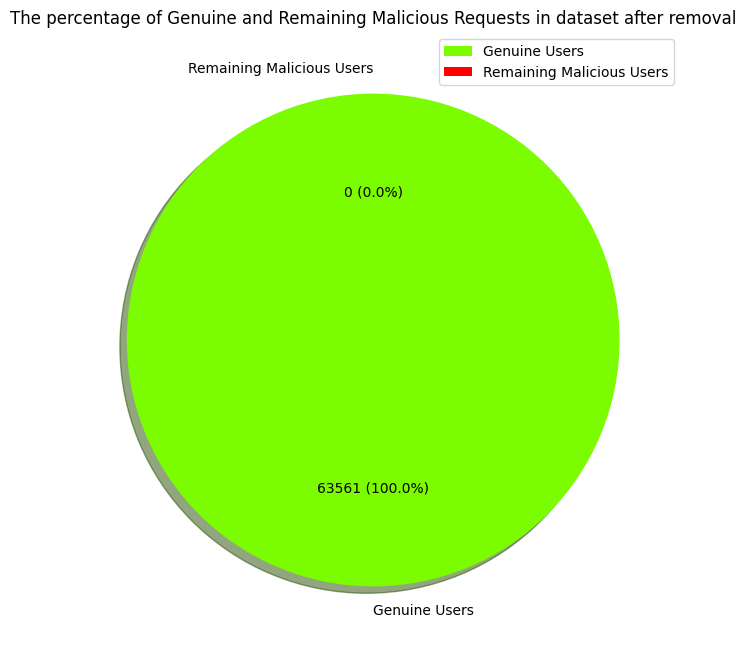

In [45]:
# Existing code for removing malicious users and displaying counts
initial_malicious_count = data[data['label'] == 1].shape[0]
data_filtered = data[data['label'] != 1]
final_malicious_count = data_filtered[data_filtered['label'] == 1].shape[0]
removed_malicious_count = initial_malicious_count - final_malicious_count

# Display the count of removed malicious users
print(f"Number of removed malicious users (DDoS attacks): {removed_malicious_count}")

# Count the number of Genuine  Users and remaining malicious users after removal
genuine_users_count = data_filtered[data_filtered['label'] == 0].shape[0]
remaining_malicious_users_count = final_malicious_count

# Display the number of Genuine  Users and remaining malicious users
print(f"Number of Genuine  Users: {genuine_users_count}")
print(f"Number of remaining malicious users: {remaining_malicious_users_count}")

# Update the pie chart after removing malicious users
labels = ["Genuine Users", "Remaining Malicious Users"]
sizes = [genuine_users_count, remaining_malicious_users_count]

# Define a function to format the labels with both count and percentage
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f'{absolute} ({pct:.1f}%)'

# Plot the pie chart before removing malicious users
plt.figure(figsize=(13, 8))
plt.pie(sizes, labels=labels, autopct=lambda pct: func(pct, sizes), shadow=True, startangle=90,colors=[ "lawngreen","red"])


plt.legend(labels)
plt.title('The percentage of Genuine and Remaining Malicious Requests in dataset after removal')
plt.show()

